$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 2: Optimization and Training
<a id=part2></a>

In this part we will learn how to implement optimization algorithms for deep networks. Additionally, we'll learn how to write training loops and implement a modular model trainer.
We'll use our optimizers and training code to test a few configurations for classifying images with an MLP model.

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
seed = 42
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Implementing Optimization Algorithms
<a id=part2_1></a>

In the context of deep learning, an optimization algorithm is some method of iteratively updating model parameters so that the loss converges toward some local minimum (which we hope will be good enough).

Gradient descent-based methods are by far the most popular algorithms for optimization of neural network parameters.
However the high-dimensional loss-surfaces we encounter in deep learning applications are highly non-convex.
They may be riddled with local minima, saddle points, large plateaus and a host of very challenging "terrain" for gradient-based optimization.
This gave rise to many different methods of performing the parameter updates based on the loss gradients,
aiming to tackle these optimization challenges.

The most basic gradient-based update rule can be written as,

$$
\vec{\theta} \leftarrow \vec{\theta} - \eta \nabla_{\vec{\theta}} L(\vec{\theta}; \mathcal{D})
$$

where $\mathcal{D} = \left\{ (\vec{x}^i, \vec{y}^i) \right\}_{i=1}^{M}$ is our training dataset or part of it. Specifically, if we have in total $N$ training samples, then
- If $M=N$ this is known as regular gradient descent. If the dataset does not fit in memory the gradient of this loss becomes infeasible to compute.
- If $M=1$, the loss is computed w.r.t. a single different sample each time. This is known as stochastic gradient descent.
- If $1<M<N$ this is known as stochastic mini-batch gradient descent. This is the most commonly-used option.

The intuition behind gradient descent is simple: since the gradient of a multivariate function points to the direction of steepest ascent ("uphill"), we move in the opposite direction. A small step size $\eta$ known as the **learning rate** is required since the gradient can only serve as a first-order linear approximation of the function's behaviour at $\vec{\theta}$ (recall e.g. the Taylor expansion).
However in truth our loss surface generally has nontrivial curvature caused by a high order nonlinear dependency on
$\vec{\theta}$.
Thus taking a large step in the direction of the gradient is actually just as likely to increase the function value.

<img src="imgs/sgd2d.png" width="600" />

The idea behind the stochastic versions is that by constantly changing the samples we compute the loss with,
we get a dynamic error surface, i.e. it's different for each set of training samples.
This is thought to generally improve the optimization since it may help the optimizer get out of flat regions or sharp local minima since these features may disappear in the loss surface of subsequent batches. The image below illustrates this. The different lines are different 1-dimensional losses for different training set-samples.

<img src="imgs/sgd1d.png" width="600" />

Deep learning frameworks generally provide implementations of various gradient-based optimization algorithms.
Here we'll implement our own optimization module from scratch, this time keeping a similar API to the PyTorch `optim` package.

We define a base `Optimizer` class. An optimizer holds a set of parameter tensors (these are the trainable parameters of some model) and maintains internal state. It may be used as follows:
- After the forward pass has been performed the optimizer's `zero_grad()` function is invoked to clear the parameter gradients computed by previous iterations.
- After the backward pass has been performed, and gradients have been calculated for these parameters, the optimizer's `step()` function is invoked in order to update the value of each parameter based on it's gradient.

The exact method of update is implementation-specific for each optimizer and may depend on its internal state. In addition, adding the regularization penalty to the gradient is handled by the optimizer since it only depends on the parameter values (and not the data).

Here's the API of our `Optimizer`:

In [95]:
import hw2.optimizers as optimizers
help(optimizers.Optimizer)

Help on class Optimizer in module hw2.optimizers:

class Optimizer(abc.ABC)
 |  Optimizer(params)
 |  
 |  Base class for optimizers.
 |  
 |  Method resolution order:
 |      Optimizer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, params)
 |      :param params: A sequence of model parameters to optimize. Can be a
 |      list of (param,grad) tuples as returned by the Blocks, or a list of
 |      pytorch tensors in which case the grad will be taken from them.
 |  
 |  step(self)
 |      Updates all the registered parameter values based on their gradients.
 |  
 |  zero_grad(self)
 |      Sets the gradient of the optimized parameters to zero (in place).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  params
 |    

## Vanilla SGD with Regularization
<a id=part2_2></a>

Let's start by implementing the simplest gradient based optimizer. The update rule will be exacly as stated above, but we'll also add a L2-regularization term to the gradient. Remember that in the **loss function**, the L2 regularization term is expressed by

$$R(\vec{\theta}) = \frac{1}{2}\lambda||\vec{\theta}||^2_2.$$

**TODO**: Complete the implementation of the `VanillaSGD` class in the `hw2/optimizers.py` module.

In [96]:
# Test VanillaSGD
torch.manual_seed(42)
p = torch.randn(500, 10)
dp = torch.randn(*p.shape)*2
params = [(p, dp)]

vsgd = optimizers.VanillaSGD(params, learn_rate=0.5, reg=0.1)
vsgd.step()

expected_p = torch.load('tests/assets/expected_vsgd.pt')
diff = torch.norm(p-expected_p).item()
print(f'diff={diff}')
test.assertLess(diff, 1e-3)

diff=0.0


## Training
<a id=part2_3></a>

Now that we can build a model and loss function, compute their gradients and we have an optimizer, we can finally do some training!

In the spirit of more modular software design, we'll implement a class that will aid us in automating the repetitive training loop code that we usually write over and over again. This will be useful for both training our `Block`-based models and also later for training PyTorch `nn.Module`s.

Here's our `Trainer` API:

In [97]:
import hw2.training as training
help(training.Trainer)

Help on class Trainer in module hw2.training:

class Trainer(abc.ABC)
 |  Trainer(model, loss_fn, optimizer, device=None)
 |  
 |  A class abstracting the various tasks of training models.
 |  
 |  Provides methods at multiple levels of granularity:
 |  - Multiple epochs (fit)
 |  - Single epoch (train_epoch/test_epoch)
 |  - Single batch (train_batch/test_batch)
 |  
 |  Method resolution order:
 |      Trainer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model, loss_fn, optimizer, device=None)
 |      Initialize the trainer.
 |      :param model: Instance of the model to train.
 |      :param loss_fn: The loss function to evaluate with.
 |      :param optimizer: The optimizer to train with.
 |      :param device: torch.device to run training on (CPU or GPU).
 |  
 |  fit(self, dl_train: torch.utils.data.dataloader.DataLoader, dl_test: torch.utils.data.dataloader.DataLoader, num_epochs, checkpoints: str = None, early_stopping: int = No

The `Trainer` class splits the task of training (and evaluating) models into three conceptual levels,
- Multiple epochs - the `fit` method, which returns a `FitResult` containing losses and accuracies for all epochs.
- Single epoch - the `train_epoch` and `test_epoch` methods, which return an `EpochResult` containing losses per batch and the single accuracy result of the epoch.
- Single batch - the `train_batch` and `test_batch` methods, which return a `BatchResult` containing a single loss and the number of correctly classified samples in the batch.

It implements the first two levels. Inheriting classes are expected to implement the single-batch level methods since these are model and/or task specific.

The first thing we should do in order to verify our model, gradient calculations and optimizer implementation is to try to overfit a large model (many parameters) to a small dataset (few images). This will show us that things are working properly.

Let's begin by loading the CIFAR-10 dataset.

In [98]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples


Now, let's implement just a small part of our training logic since that's what we need right now.

**TODO**:
1. Complete the implementation of the `train_batch()` method in the `BlocksTrainer` class within the `hw2/training.py` module.
1. Update the hyperparameter values in the `part2_overfit_hp()` function in the `hw2/answers.py` module. Tweak the hyperparameter values until your model overfits a small number of samples in the block below. You should get 100% accuracy within a few epochs.

The following block will use your custom `Block`-based MLP implentation, custom Vanilla SGD and custom trainer to overfit the data. The classification accuracy should be 100% within a few epochs.

In [99]:
import hw2.blocks as blocks
import hw2.answers as answers
from torch.utils.data import DataLoader

# Overfit to a very small dataset of 20 samples
batch_size = 10
max_batches = 2
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Get hyperparameters
hp = answers.part2_overfit_hp()

torch.manual_seed(seed)

# Build a model and loss using our custom MLP and CE implementations
model = blocks.MLP(3*32*32, num_classes=10, hidden_features=[128]*3, wstd=hp['wstd'])
loss_fn = blocks.CrossEntropyLoss()

# Use our custom optimizer
optimizer = optimizers.VanillaSGD(model.params(), learn_rate=hp['lr'], reg=hp['reg'])

# Run training over small dataset multiple times
trainer = training.BlocksTrainer(model, loss_fn, optimizer)
best_acc = 0
for i in range(20):
    res = trainer.train_epoch(dl_train, max_batches=max_batches)
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
test.assertGreaterEqual(best_acc, 98)

train_batch (Avg. Loss 0.086, Accuracy 100.0): 100%|█████████████████████████████████████| 2/2 [00:00<00:00, 19.28it/s]


Now that we know training works, let's try to fit a model to a bit more data for a few epochs, to see how well we're doing. First, we need a function to plot the FitResults object.

In [100]:
from cs236781.plot import plot_fit
plot_fit?

Signature:
plot_fit(
    fit_res: cs236781.train_results.FitResult,
    fig=None,
    log_loss=False,
    legend=None,
)
Docstring:
Plots a FitResult object.
Creates four plots: train loss, test loss, train acc, test acc.
:param fit_res: The fit result to plot.
:param fig: A figure previously returned from this function. If not None,
    plots will the added to this figure.
:param log_loss: Whether to plot the losses in log scale.
:param legend: What to call this FitResult in the legend.
:return: The figure.
File:      c:\users\user\onedrive - technion\semester h\dl\dl_hw2\cs236781\plot.py
Type:      function


**TODO**:
1. Complete the implementation of the `test_batch()` method in the `BlocksTrainer` class within the `hw2/training.py` module.
1. Implement the `fit()` method of the `Trainer` class within the `hw2/training.py` module.
1. Tweak the hyperparameters for this section in the `part2_optim_hp()` function in the `hw2/answers.py` module.
1. Run the following blocks to train. Try to get above 35-40% test-set accuracy.

In [116]:
# Define a larger part of the CIFAR-10 dataset (still not the whole thing)
batch_size = 50
max_batches = 100
in_features = 3*32*32
num_classes = 10
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size//2, shuffle=False)

In [117]:
# Define a function to train a model with our Trainer and various optimizers
def train_with_optimizer(opt_name, opt_class, fig):
    torch.manual_seed(seed)
    
    # Get hyperparameters
    hp = answers.part2_optim_hp()
    hidden_features = [128] * 5
    num_epochs = 10
    
    # Create model, loss and optimizer instances
    model = blocks.MLP(in_features, num_classes, hidden_features, wstd=hp['wstd'])
    loss_fn = blocks.CrossEntropyLoss()
    optimizer = opt_class(model.params(), learn_rate=hp[f'lr_{opt_name}'], reg=hp['reg'])

    # Train with the Trainer
    trainer = training.BlocksTrainer(model, loss_fn, optimizer)
    fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=max_batches)
    
    fig, axes = plot_fit(fit_res, fig=fig, legend=opt_name)
    return fig

--- EPOCH 1/10 ---
test_batch (Avg. Loss 1.725, Accuracy 39.5): 100%|███████████████████████████████████| 400/400 [00:04<00:00, 92.08it/s]
--- EPOCH 2/10 ---
test_batch (Avg. Loss 1.630, Accuracy 42.0): 100%|███████████████████████████████████| 400/400 [00:04<00:00, 97.51it/s]
--- EPOCH 3/10 ---
test_batch (Avg. Loss 1.601, Accuracy 42.7): 100%|███████████████████████████████████| 400/400 [00:04<00:00, 94.66it/s]
--- EPOCH 4/10 ---
test_batch (Avg. Loss 1.587, Accuracy 43.2): 100%|███████████████████████████████████| 400/400 [00:04<00:00, 96.18it/s]
--- EPOCH 5/10 ---
test_batch (Avg. Loss 1.530, Accuracy 45.8): 100%|███████████████████████████████████| 400/400 [00:04<00:00, 95.04it/s]
--- EPOCH 6/10 ---
test_batch (Avg. Loss 1.519, Accuracy 45.9): 100%|███████████████████████████████████| 400/400 [00:04<00:00, 95.15it/s]
--- EPOCH 7/10 ---
test_batch (Avg. Loss 1.546, Accuracy 45.2): 100%|███████████████████████████████████| 400/400 [00:04<00:00, 82.39it/s]
--- EPOCH 8/10 ---
test_bat

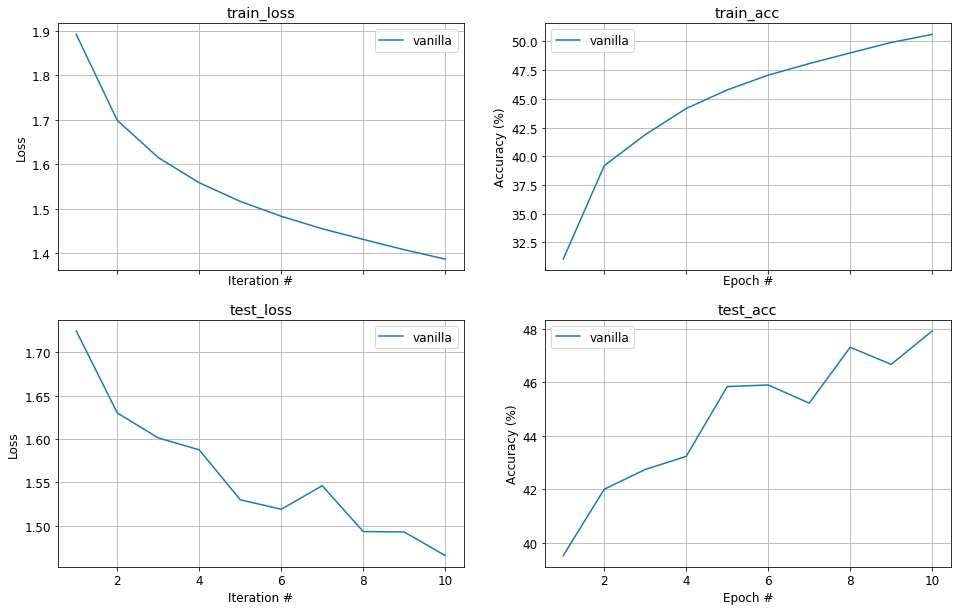

In [118]:
fig_optim = None
fig_optim = train_with_optimizer('vanilla', optimizers.VanillaSGD, fig_optim)

## Momentum
<a id=part2_4></a>

The simple vanilla SGD update is rarely used in practice since it's very slow to converge relative to other optimization algorithms.

One reason is that naïvely updating in the direction of the current gradient causes it to fluctuate wildly in areas where the loss surface in some dimensions is much steeper than in others.
Another reason is that using the same learning rate for all parameters is not a great idea since not all parameters are created equal. For example, parameters associated with rare features should be updated with a larger step than ones associated with commonly-occurring features because they'll get less updates through the gradients.

Therefore more advanced optimizers take into account the previous gradients of a parameter and/or try to use a per-parameter specific learning rate instead of a common one.

Let's now implement a simple and common optimizer: SGD with Momentum. This optimizer takes **previous gradients** of a parameter into account when updating it's value instead of just the current one. In practice it usually provides faster convergence than the vanilla SGD.

The SGD with Momentum update rule can be stated as follows:
$$\begin{align}
\vec{v}_{t+1} &= \mu \vec{v}_t - \eta \delta \vec{\theta}_t \\
\vec{\theta}_{t+1} &= \vec{\theta}_t + \vec{v}_{t+1}
\end{align}$$

Where $\eta$ is the learning rate,
$\vec{\theta}$ is a model parameter,
$\delta \vec{\theta}_t=\pderiv{L}{\vec{\theta}}(\vec{\theta}_t)$ is the gradient of the loss w.r.t. to the parameter and $0\leq\mu<1$ is a hyperparameter known as momentum. 

Expanding the update rule recursively shows us now the parameter update infact depends on all previous gradient values for that parameter, where the old gradients are exponentially decayed by a factor of $\mu$ at each timestep. 

Since we're incorporating previous gradient (update directions), a noisy value of the current gradient will have less effect so that the general direction of previous updates is maintained somewhat. The following figure illustrates this.

<img src="imgs/sgd-momentum.png" width="600" />



**TODO**:
1. Complete the implementation of the `MomentumSGD` class in the `hw2/optimizers.py` module.
1. Tweak the learning rate for momentum in `part2_optim_hp()` the function in the `hw2/answers.py` module.
1. Run the following block to compare to the vanilla SGD.

In [ ]:
fig_optim = train_with_optimizer('momentum', optimizers.MomentumSGD, fig_optim)
fig_optim

## RMSProp
<a id=part2_5></a>

This is another optmizer that accounts for previous gradients, but this time it uses them to adapt the learning rate per parameter.

RMSProp maintains a decaying moving average of previous squared gradients,
$$
\vec{r}_{t+1} = \gamma\vec{r}_{t} + (1-\gamma)\delta\vec{\theta}_t^2
$$
where $0<\gamma<1$ is a decay constant usually set close to $1$, and $\delta\vec{\theta}_t^2$ denotes
element-wise squaring.

The update rule for each parameter is then,
$$
\vec{\theta}_{t+1} = \vec{\theta}_t - \left( \frac{\eta}{\sqrt{r_{t+1}+\varepsilon}} \right) \delta\vec{\theta}_t
$$

where $\varepsilon$ is a small constant to prevent numerical instability. The idea here is to decrease the learning rate for parameters with high gradient values and vice-versa. The decaying moving average prevents accumulating all the past gradients which would cause the effective learning rate to become zero.

**TODO**:
1. Complete the implementation of the `RMSProp` class in the `hw2/optimizers.py` module.
1. Tweak the learning rate for RMSProp in `part2_optim_hp()` the function in the `hw2/answers.py` module.
1. Run the following block to compare to the other optimizers.

In [ ]:
fig_optim = train_with_optimizer('rmsprop', optimizers.RMSProp, fig_optim)
fig_optim

Note that you should get better train/test accuracy with Momentum and RMSProp than Vanilla.

## Dropout Regularization
<a id=part2_6></a>

[Dropout](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) is a useful technique to improve generalization of deep models.

The idea is simple: during the forward pass drop, i.e. set to to zero, the activation of each neuron, with a probability of $p$. For example, if $p=0.4$ this means we **drop** the activations of 40% of the neurons (on average).

There are a few important things to note about dropout:
1. It is only performed during training. When testing our model the dropout layers should be a no-op.
1. In the backward pass, gradients are only propagated back into neurons that weren't dropped during the forward pass.
1. During testing, the activations must be scaled since the expected value of each neuron during the training phase is now $1-p$ times it's original expectation. Thus, we need to scale the test-time activations by $1-p$ to match. Equivalently, we can scale the train time activations by $1/(1-p)$.

**TODO**: 
1. Complete the implementation of the `Dropout` class in the `hw2/blocks.py` module.
2. Finish the implementation of the `MLP`'s `__init__()` method in the `hw2/blocks.py` module.
   If `dropout>0` you should add a `Dropout` block after each `ReLU`.

In [ ]:
from hw2.grad_compare import compare_block_to_torch

# Check architecture of MLP with dropout layers
mlp_dropout = blocks.MLP(in_features, num_classes, [50]*3, dropout=0.6)
print(mlp_dropout)
test.assertEqual(len(mlp_dropout.sequence), 10)
for b1, b2 in zip(mlp_dropout.sequence, mlp_dropout.sequence[1:]):
    if str(b1) == 'relu':
        test.assertTrue(str(b2).startswith('Dropout'))
test.assertTrue(str(mlp_dropout.sequence[-1]).startswith('Linear'))

In [ ]:
# Test end-to-end gradient in train and test modes.
print('Dropout, train mode')
mlp_dropout.train(True)
for diff in compare_block_to_torch(mlp_dropout, torch.randn(500, in_features)):
    test.assertLess(diff, 1e-3)
    
print('Dropout, test mode')
mlp_dropout.train(False)
for diff in compare_block_to_torch(mlp_dropout, torch.randn(500, in_features)):
    test.assertLess(diff, 1e-3)

To see whether dropout really improves generalization, let's take a small training set
(small enough to overfit) and a large test set and check whether we get less overfitting and
perhaps improved test-set accuracy when using dropout.

In [ ]:
# Define a small set from CIFAR-10, but take a larger test set since we want to test generalization
batch_size = 10
max_batches = 40
in_features = 3*32*32
num_classes = 10
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size*2, shuffle=False)

**TODO**:
Tweak the hyperparameters for this section in the `part2_dropout_hp()` function in the `hw2/answers.py` module. Try to set them so that the first model (with `dropout`=0) overfits. You can disable the other dropout options until you tune the hyperparameters. We can then see the effect of dropout for generalization.

In [ ]:
# Get hyperparameters
hp = answers.part2_dropout_hp()
hidden_features = [400] * 1
num_epochs = 30

In [ ]:
torch.manual_seed(seed)
fig=None
#for dropout in [0]:  # Use this for tuning the hyperparms until you overfit
for dropout in [0, 0.4, 0.8]:
    model = blocks.MLP(in_features, num_classes, hidden_features, wstd=hp['wstd'], dropout=dropout)
    loss_fn = blocks.CrossEntropyLoss()
    optimizer = optimizers.MomentumSGD(model.params(), learn_rate=hp['lr'], reg=0)

    print('*** Training with dropout=', dropout)
    trainer = training.BlocksTrainer(model, loss_fn, optimizer)
    fit_res_dropout = trainer.fit(dl_train, dl_test, num_epochs, max_batches=max_batches, print_every=6)
    fig, axes = plot_fit(fit_res_dropout, fig=fig, legend=f'dropout={dropout}', log_loss=True)

## Questions
<a id=part2_7></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [ ]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1 

Regarding the graphs you got for the three dropout configurations:

1. Explain the graphs of no-dropout vs dropout. Do they match what you expected to see?
    - If yes, explain why and provide examples based on the graphs.
    - If no, explain what you think the problem is and what should be modified to fix it.

2. Compare the low-dropout setting to the high-dropout setting and explain based on your graphs.

In [ ]:
display_answer(hw2.answers.part2_q1)

### Question 2 

When training a model with the cross-entropy loss function, is it possible for the test loss to **increase** for a few epochs while the test accuracy also **increases**?

If it's possible explain how, if it's not explain why not.

In [ ]:
display_answer(hw2.answers.part2_q2)